In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq xgboost==2.0.3 --progress-bar off
!pip install -Uqqq gdown --progress-bar off
!pip install -qqq matplotlib-venn==0.11.10 --progress-bar off

In [2]:
import inspect
import random
import re
import sqlite3

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = [
    "#bae1ff",
    "#ffb3ba",
    "#ffdfba",
    "#ffffba",
    "#baffc9",
    "#b3baff",
    "#ffb3ff",
    "#d9b3ff",
]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)
SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)

## Classification

In [3]:
!gdown 1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz

Downloading...
From: https://drive.google.com/uc?id=1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz
To: /content/crypto-news-db.zip
100% 4.85M/4.85M [00:00<00:00, 31.5MB/s]


In [4]:
!unzip crypto-news-db.zip

Archive:  crypto-news-db.zip
  inflating: crypto-news.db          


In [5]:
connection = sqlite3.connect("crypto-news.db")
train_df = pd.read_sql_query("SELECT * FROM train", connection)
test_df = pd.read_sql_query("SELECT * FROM test", connection)
train_df.shape, test_df.shape

((24829, 9), (1242, 9))

In [6]:
train_df.head()

,date,source,subject,text,title,url,sentiment,polarity,subjectivity
0,2022-04-12 12:02:00,CryptoPotato,ethereum,IDEG's new investment vehicle is part of its t...,IDEG Appoints Coinbase Prime as Strategic Part...,https://cryptopotato.com/ideg-appoints-coinbas...,positive,0.05,0.18
1,2022-10-26 18:00:00,CryptoNews,altcoin,"IBAT, the project's token of Battle infinity, ...",Battle Infinity Token Trending on CoinGecko - ...,https://cryptonews.com/news/battle-infinity-to...,positive,0.55,0.70
2,2023-02-08 16:00:00,CryptoNews,altcoin,"Get your daily, bite-sized digest of cryptoass...",Today in Crypto: Brave Reveals Solana Dapp Sup...,https://cryptonews.com/news/today-crypto-brave...,neutral,0.00,0.00
3,2022-03-05 19:20:00,CryptoPotato,blockchain,A BlockFi study found out that US women have s...,33% of Surveyed American Women Intend to Buy C...,https://cryptopotato.com/33-of-surveyed-americ...,neutral,0.00,0.00
4,2022-04-20 19:16:24,CoinTelegraph,blockchain,The symbol was quickly 'erased' via a communit...,Shiba Inu blacklists user for drawing hate sym...,https://cointelegraph.com/news/shiba-inu-black...,positive,0.33,0.50


In [7]:
train_df.subject.value_counts()

bitcoin       7974
altcoin       7422
blockchain    5557
ethereum      1819
nft           1227
defi           830
Name: subject, dtype: int64

In [8]:
train_df.sentiment.value_counts()

positive    11170
neutral      8444
negative     5215
Name: sentiment, dtype: int64

In [9]:
def create_grid(n_rows, n_columns):
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_columns, figsize=(n_columns * 5, n_rows * 4)
    )
    return fig, axes.flatten()

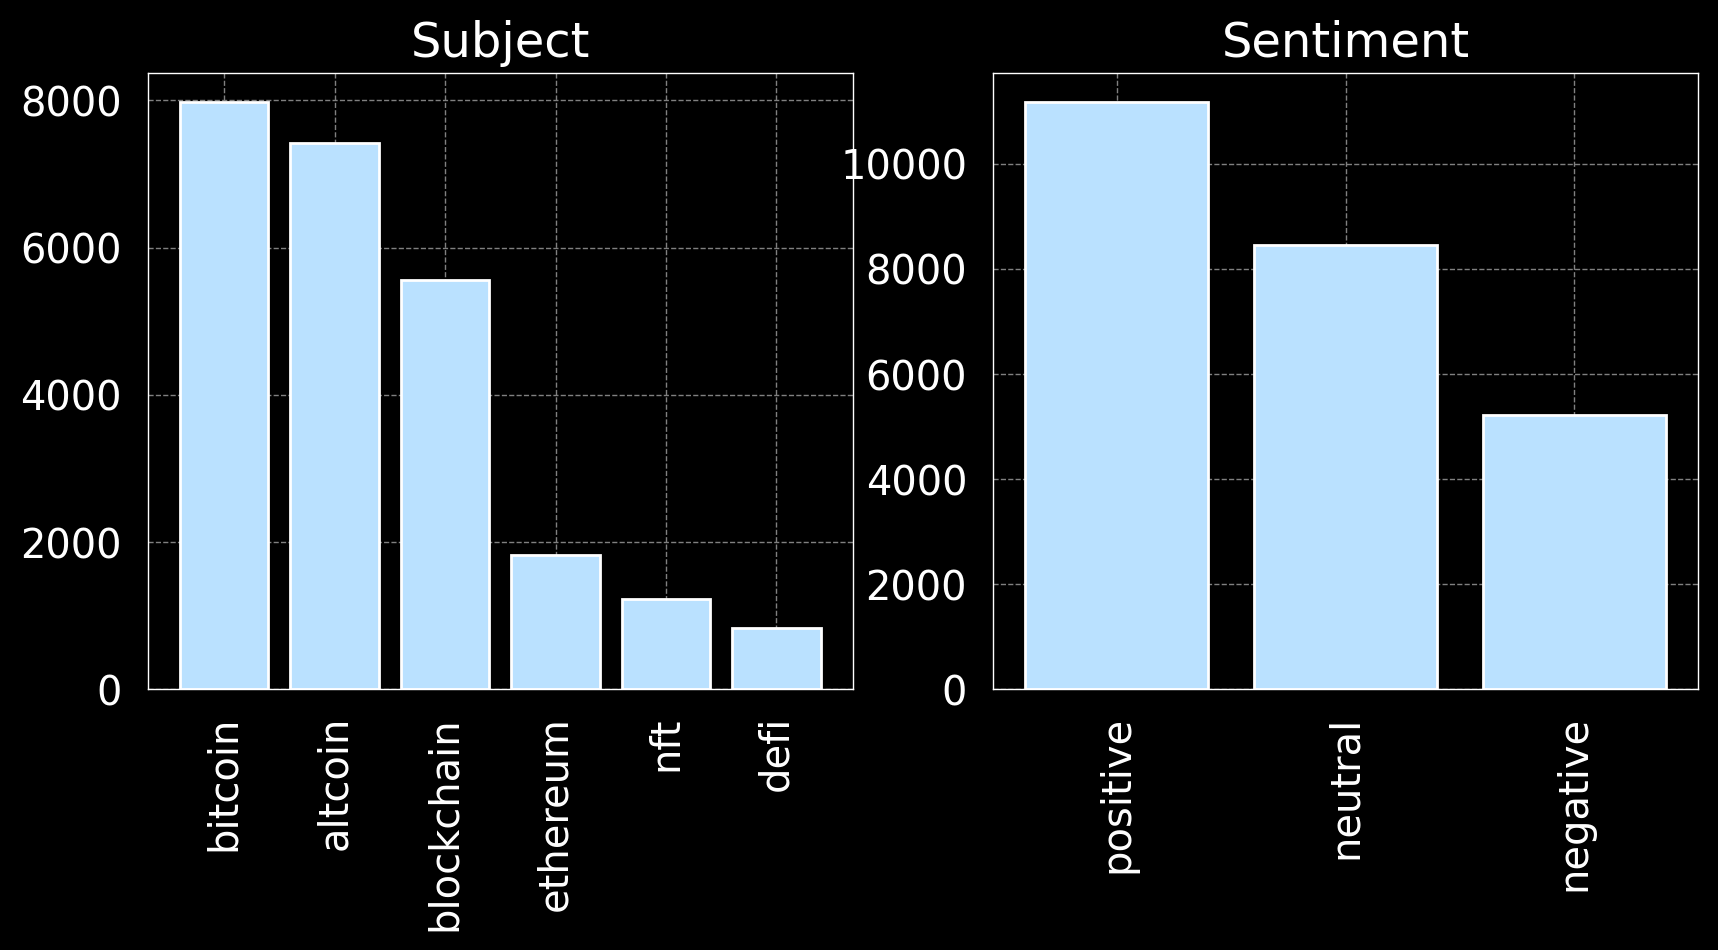

In [10]:
fig, (sub_ax, sent_ax) = create_grid(n_rows=1, n_columns=2)

subjects = train_df.subject.value_counts()
sentiments = train_df.sentiment.value_counts()

sub_ax.bar(subjects.index, subjects.values)
sub_ax.set_title("Subject")
sub_ax.set_xticks(range(len(subjects.index)))
sub_ax.set_xticklabels(subjects.index, rotation=90)

sent_ax.bar(sentiments.index, sentiments.values)
sent_ax.set_title("Sentiment")
sent_ax.set_xticks(range(len(sentiments.index)))
sent_ax.set_xticklabels(sentiments.index, rotation=90)

plt.show();

In [11]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df.title)
X_test = vectorizer.transform(test_df.title)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df.subject)
y_test = label_encoder.transform(test_df.subject)

model = xgb.XGBClassifier(n_jobs=-1, n_estimators=10, max_depth=2)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

### Accuracy

In [12]:
predictions = np.array(predictions)
y_test = np.array(y_test)
correct_predictions = np.sum(y_test == predictions)
correct_predictions / len(y_test)

0.6304347826086957

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.6304347826086957

In [14]:
def calculate_accuracy_per_class(y_test, predictions, class_names):
    y_test, predictions = np.array(y_test), np.array(predictions)
    accuracy_per_class = {}

    for idx, cls_name in enumerate(class_names):
        # True Positives (TP): Predictions match the actual class
        TP = np.sum((predictions == idx) & (y_test == idx))
        # True Negatives (TN), False Positives (FP), and False Negatives (FN) don't directly apply to per-class accuracy

        # Total predictions for this class
        total_predictions = np.sum(predictions == idx)
        # Total actual instances of this class
        total_actual = np.sum(y_test == idx)

        # Calculating a form of accuracy for the class: correctly identified instances over total instances of this class
        # This approach considers both predictions and actual instances to avoid bias towards classes with fewer instances
        accuracy = TP / max(
            total_predictions + total_actual - TP, 1
        )  # Adjusted to avoid overestimating accuracy

        accuracy_per_class[cls_name] = accuracy

    return accuracy_per_class


calculate_accuracy_per_class(y_test, predictions, label_encoder.classes_)

{'altcoin': 0.4641873278236915,
 'bitcoin': 0.6774941995359629,
 'blockchain': 0.1864406779661017,
 'defi': 0.1346153846153846,
 'ethereum': 0.4444444444444444,
 'nft': 0.4943820224719101}

### Precision

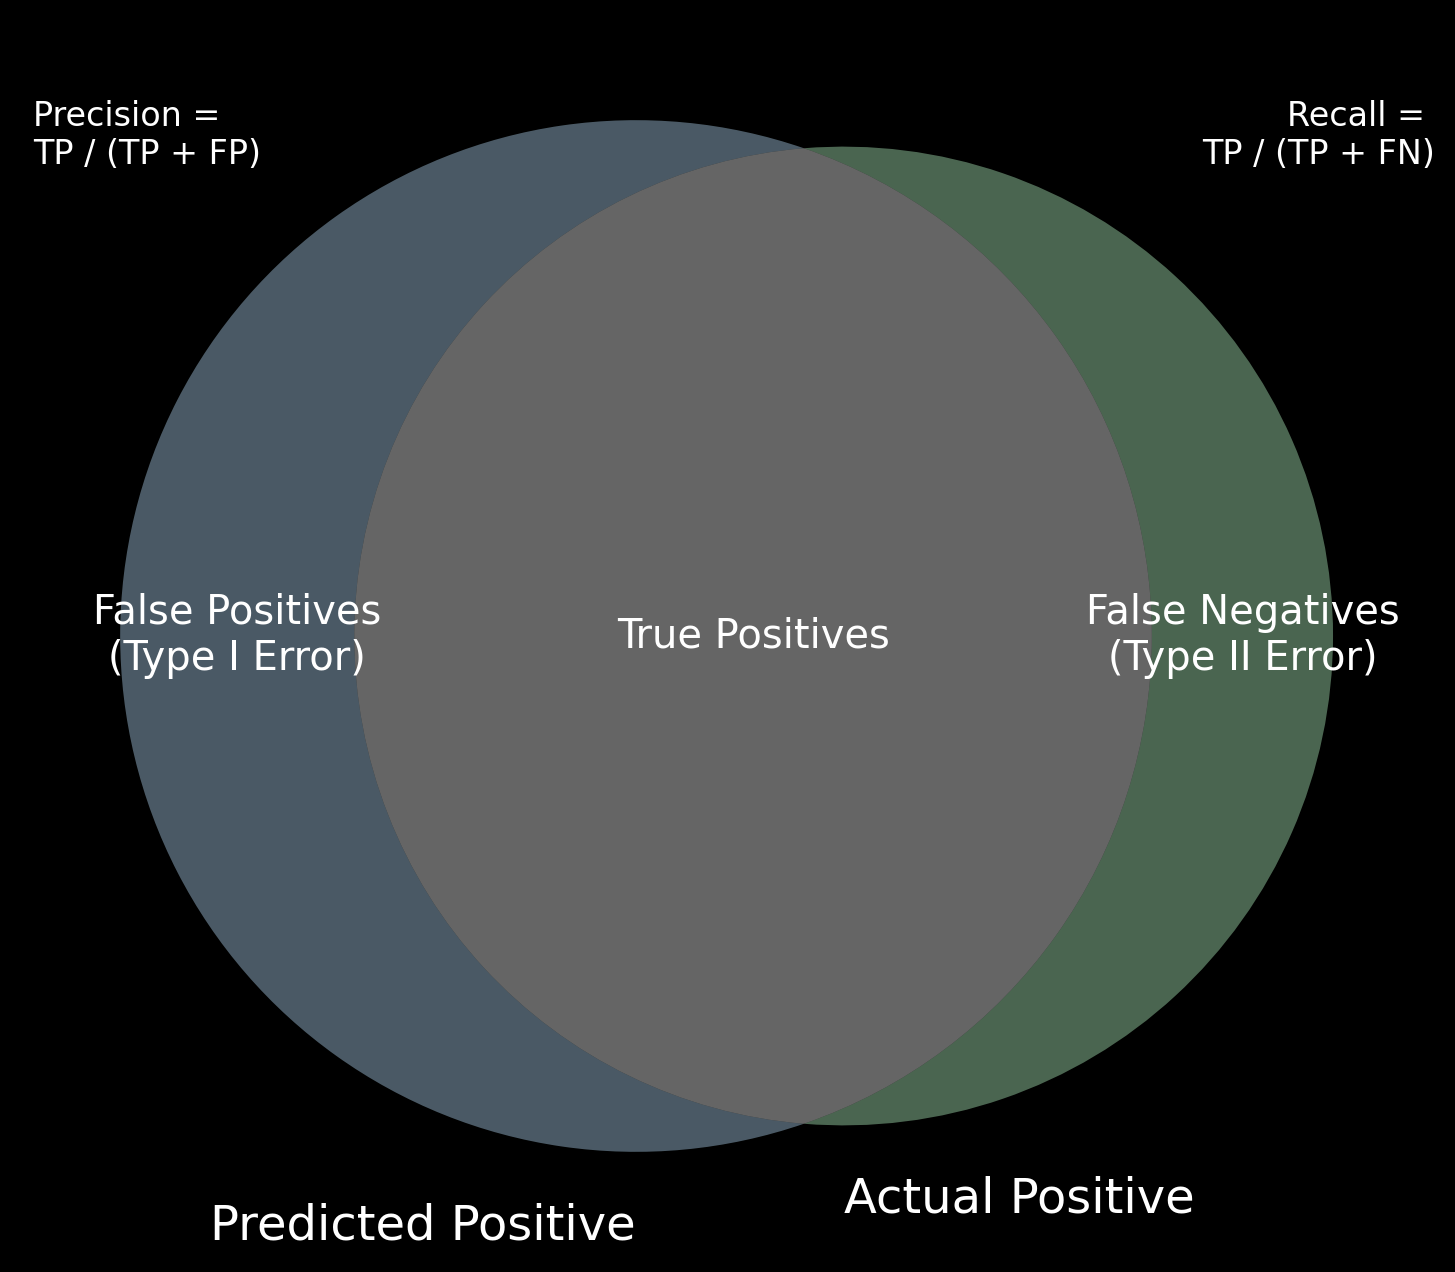

In [15]:
from matplotlib_venn import venn2, venn2_circles

true_positives = 70  # Correctly identified
false_positives = 30  # Incorrectly identified
false_negatives = 20  # Missed

plt.figure(figsize=(12, 8))
venn = venn2(
    subsets=(false_positives, false_negatives, true_positives),
    set_labels=("Predicted Positive", "Actual Positive"),
    set_colors=[COLORS[0], COLORS[4]],
)

venn.get_label_by_id("10").set_text("False Positives\n(Type I Error)")
venn.get_label_by_id("01").set_text("False Negatives\n(Type II Error)")
venn.get_label_by_id("11").set_text("True Positives")

plt.text(-0.7, 0.5, "Precision = \nTP / (TP + FP)", size=12, ha="left", va="center")
plt.text(0.7, 0.5, "Recall = \nTP / (TP + FN)", size=12, ha="right", va="center")

plt.show()

In [16]:
def calculate_precision_per_class(y_test, predictions, class_names):
    y_test, predictions = np.array(y_test), np.array(predictions)
    precision_per_class = {}

    for idx, cls_name in enumerate(class_names):
        # True Positives (TP): Predictions match the actual class
        TP = np.sum((predictions == idx) & (y_test == idx))
        # False Positives (FP): Predictions are the class, but actuals are not
        FP = np.sum((predictions == idx) & (y_test != idx))

        # Avoid division by zero
        precision = TP / max(TP + FP, 1)

        # Use class name instead of index for clarity
        precision_per_class[cls_name] = precision

    return precision_per_class


pd.DataFrame(
    [calculate_precision_per_class(y_test, predictions, label_encoder.classes_)]
)

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.487699,0.901235,0.763889,0.388889,0.738462,0.611111


In [17]:
from sklearn.metrics import precision_score

per_class_precision = precision_score(y_test, predictions, average=None)
pd.DataFrame([per_class_precision], columns=label_encoder.classes_)

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.487699,0.901235,0.763889,0.388889,0.738462,0.611111


### Recall

In [18]:
def calculate_recall_per_class(y_test, predictions, class_names):
    y_test, predictions = np.array(y_test), np.array(predictions)
    recall_per_class = {}

    for idx, cls_name in enumerate(class_names):
        # True Positives (TP): Predictions match the actual class
        TP = np.sum((predictions == idx) & (y_test == idx))
        # False Negatives (FN): Actuals are the class, but predictions are not
        FN = np.sum((predictions != idx) & (y_test == idx))

        # Avoid division by zero
        recall = TP / max(TP + FN, 1)

        # Use class name instead of index for clarity
        recall_per_class[cls_name] = recall

    return recall_per_class


pd.DataFrame([calculate_recall_per_class(y_test, predictions, label_encoder.classes_)])

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.905914,0.73183,0.197842,0.170732,0.527473,0.721311


In [19]:
from sklearn.metrics import recall_score

per_class_recall = recall_score(y_test, predictions, average=None)
pd.DataFrame([per_class_recall], columns=label_encoder.classes_)

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.905914,0.73183,0.197842,0.170732,0.527473,0.721311


### F1 Score

In [20]:
def calculate_f1_score_per_class(y_test, predictions, class_names):
    y_test, predictions = np.array(y_test), np.array(predictions)
    f1_scores_per_class = {}

    for idx, cls_name in enumerate(class_names):
        # True Positives (TP): Predictions match the actual class
        TP = np.sum((predictions == idx) & (y_test == idx))
        # False Positives (FP): Predictions are the class, but actuals are not
        FP = np.sum((predictions == idx) & (y_test != idx))
        # False Negatives (FN): Actuals are the class, but predictions are not
        FN = np.sum((predictions != idx) & (y_test == idx))

        # Precision and Recall calculations
        precision = TP / max(TP + FP, 1)
        recall = TP / max(TP + FN, 1)

        # F1 Score calculation
        f1_score = 2 * (precision * recall) / max(precision + recall, 1)

        # Use class name for clarity
        f1_scores_per_class[cls_name] = f1_score

    return f1_scores_per_class


pd.DataFrame(
    [calculate_f1_score_per_class(y_test, predictions, label_encoder.classes_)]
)

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.634055,0.807746,0.302258,0.132791,0.615385,0.661654


In [21]:
from sklearn.metrics import f1_score

per_class_f1 = f1_score(y_test, predictions, average=None)
pd.DataFrame([per_class_f1], columns=label_encoder.classes_)

,altcoin,bitcoin,blockchain,defi,ethereum,nft
0,0.634055,0.807746,0.314286,0.237288,0.615385,0.661654


### ROC/AUC

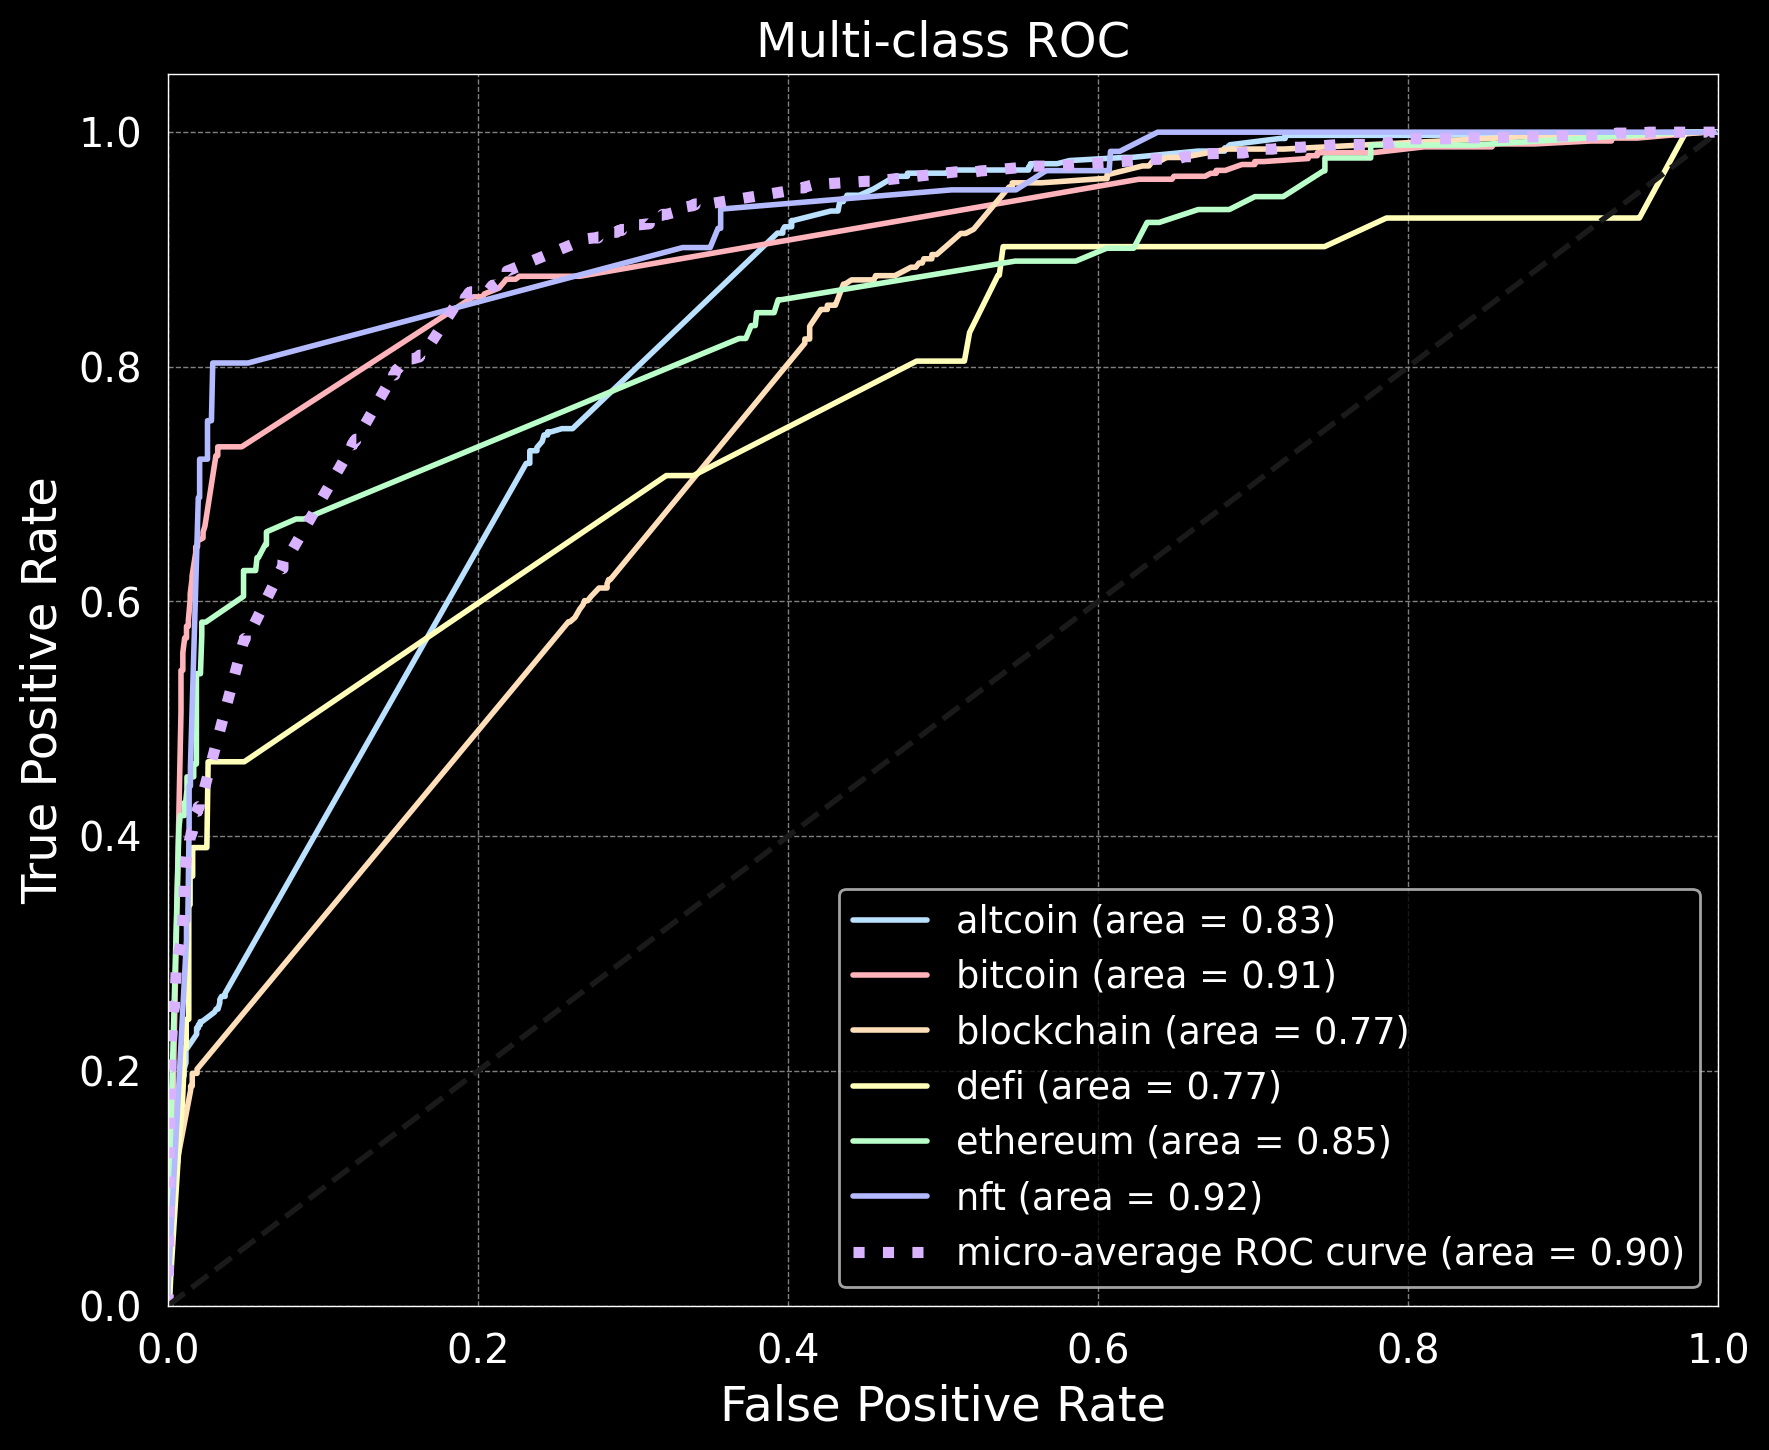

In [22]:
import itertools

import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

color_cycle = itertools.cycle(COLORS)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(
        fpr[i],
        tpr[i],
        color=next(color_cycle),
        lw=2,
        label="{} (area = {:0.2f})".format(class_name, roc_auc[i]),
    )

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color=COLORS[-1],
    linestyle=":",
    linewidth=4,
    label="micro-average ROC curve (area = {:0.2f})".format(roc_auc["micro"]),
)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC")
plt.legend(loc="lower right")
plt.show()

### Classification report

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions, target_names=label_encoder.classes_)

print(report)

              precision    recall  f1-score   support

     altcoin       0.49      0.91      0.63       372
     bitcoin       0.90      0.73      0.81       399
  blockchain       0.76      0.20      0.31       278
        defi       0.39      0.17      0.24        41
    ethereum       0.74      0.53      0.62        91
         nft       0.61      0.72      0.66        61

    accuracy                           0.63      1242
   macro avg       0.65      0.54      0.55      1242
weighted avg       0.70      0.63      0.61      1242



### Confusion matrix

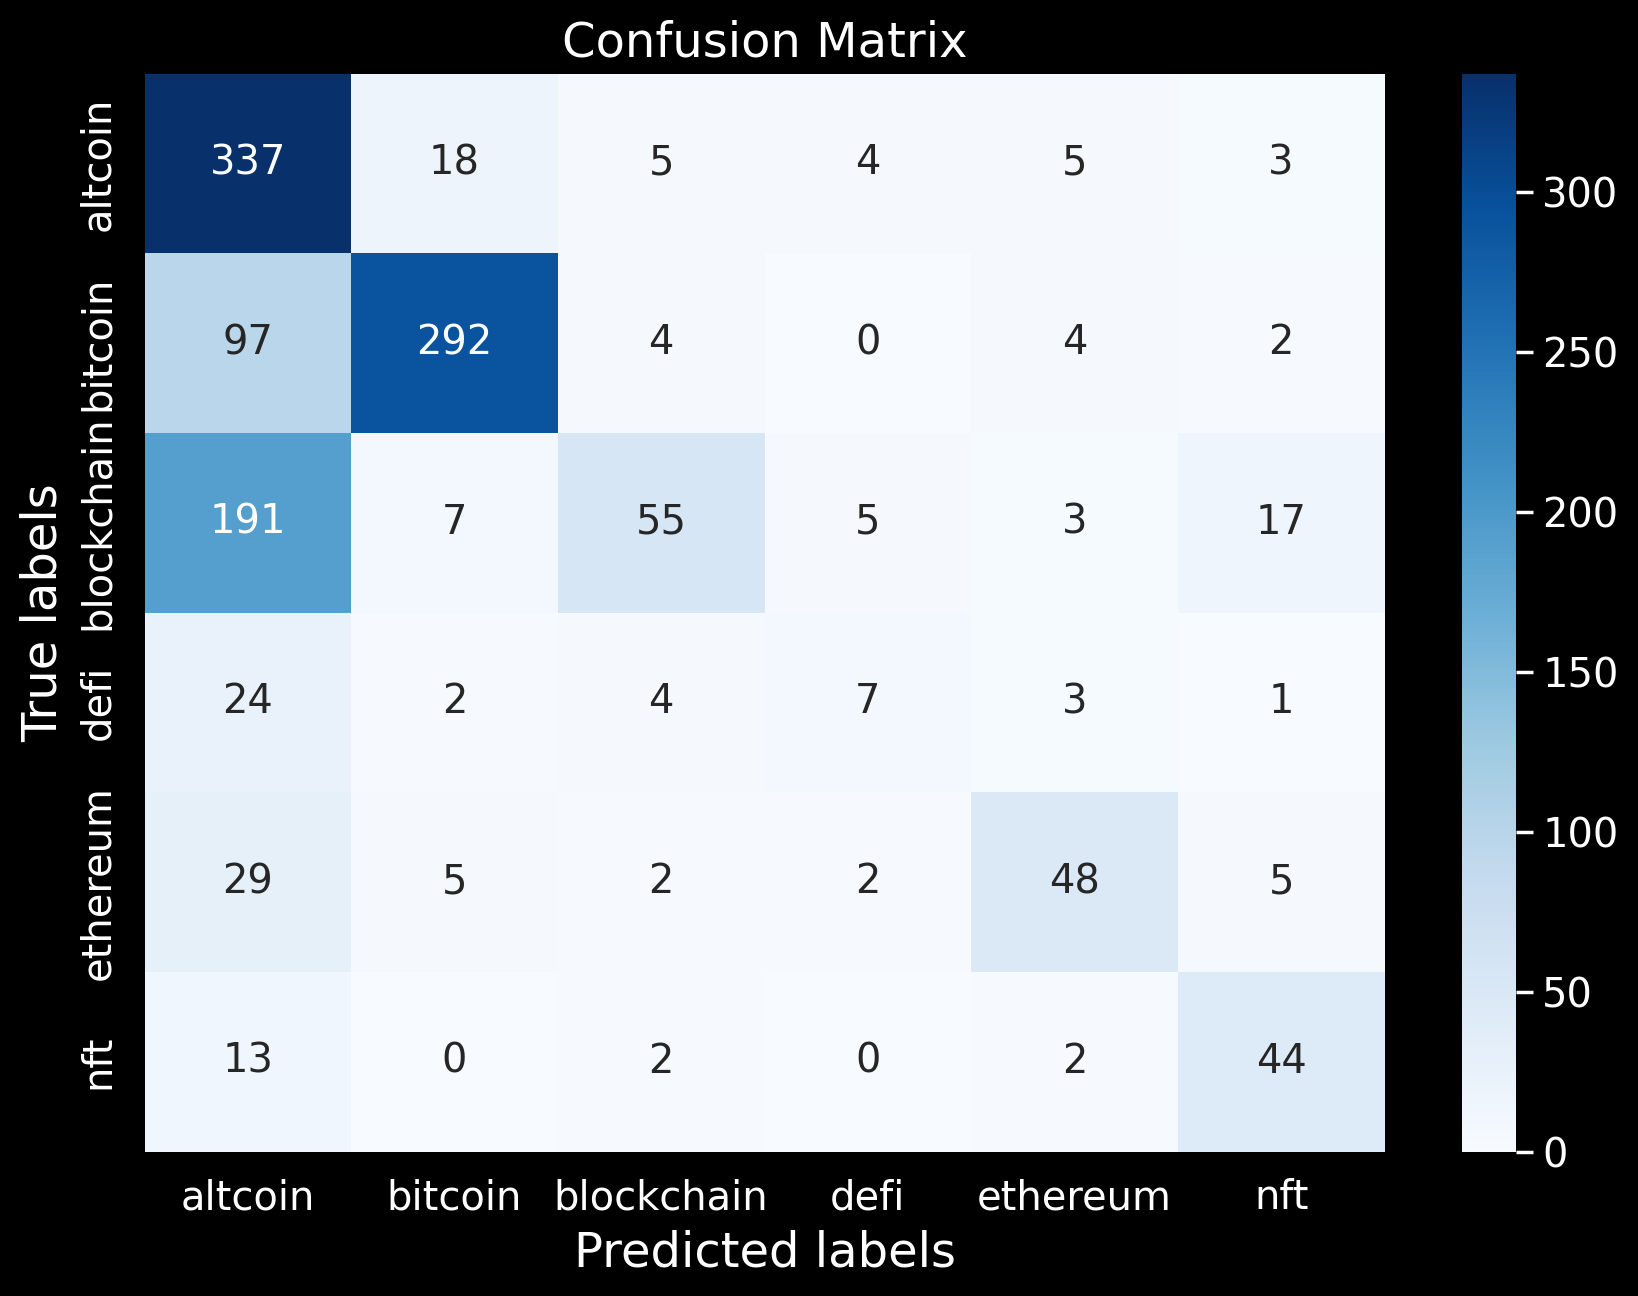

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Regression

In [25]:
!gdown 1M2IL15K1-LyurbHlNo2iRRBGmxqO_Bny

Downloading...
From: https://drive.google.com/uc?id=1M2IL15K1-LyurbHlNo2iRRBGmxqO_Bny
To: /content/fitbit-daily-activity.csv
100% 111k/111k [00:00<00:00, 2.86MB/s]


In [26]:
df = pd.read_csv("fitbit-daily-activity.csv")
pattern = re.compile(r"(?<!^)(?=[A-Z])")
column_names = [pattern.sub("_", name).lower() for name in df.columns]
df.columns = column_names
df.head()

,id,activity_date,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [27]:
user_ids = df.groupby("id").apply(lambda df: df.sample(1)).reset_index(drop=True).id
shuffled_ids = np.random.permutation(user_ids)

train_ids, test_ids = train_test_split(shuffled_ids, test_size=0.2, random_state=42)

train_df = df[df["id"].isin(train_ids)]
test_df = df[df["id"].isin(test_ids)]

In [28]:
train_df.head()

,id,activity_date,total_steps,total_distance,tracker_distance,logged_activities_distance,very_active_distance,moderately_active_distance,light_active_distance,sedentary_active_distance,very_active_minutes,fairly_active_minutes,lightly_active_minutes,sedentary_minutes,calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [29]:
import xgboost as xgb

X_train = train_df[["total_distance", "very_active_minutes"]]
y_train = train_df.calories

X_test = test_df[["total_distance", "very_active_minutes"]]
y_test = test_df.calories

model = xgb.XGBRegressor(n_jobs=-1, n_estimators=10, max_depth=2)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

### MAE

In [30]:
def calculate_mae(y_test, predictions):
    # Convert inputs to numpy arrays to ensure compatibility with NumPy operations
    y_test, predictions = np.array(y_test), np.array(predictions)

    # Calculate the absolute differences between the actual and predicted values
    absolute_errors = np.abs(y_test - predictions)

    # Calculate the mean of these absolute differences
    mae = np.mean(absolute_errors)

    return mae


calculate_mae(y_test, predictions)

427.1632656521267

In [28]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, predictions)

427.1632656521267

### MSE

In [31]:
def calculate_mse(y_test, predictions):
    # Convert inputs to numpy arrays to ensure compatibility with NumPy operations
    y_test, predictions = np.array(y_test), np.array(predictions)

    # Calculate the squared differences between the actual and predicted values
    squared_errors = np.square(y_test - predictions)

    # Calculate the mean of these squared differences
    mse = np.mean(squared_errors)

    return mse


calculate_mse(y_test, predictions)

245402.43702803124

In [29]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

245402.43702803124

### RMSE

In [30]:
np.sqrt(mse)

495.38110281684266

### $R^2$

In [32]:
def calculate_r_squared(y_test, predictions):
    # Convert inputs to numpy arrays to ensure compatibility with NumPy operations
    y_test, predictions = np.array(y_test), np.array(predictions)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_test - np.mean(y_test)) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_test - predictions) ** 2)

    # Calculate R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


calculate_r_squared(y_test, predictions)

0.5954164977350846

In [31]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, predictions)
r_squared

0.5954164977350846

### Adjusted $R^2$

In [32]:
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
adjusted_r_squared

0.5916175916105315

### Residuals

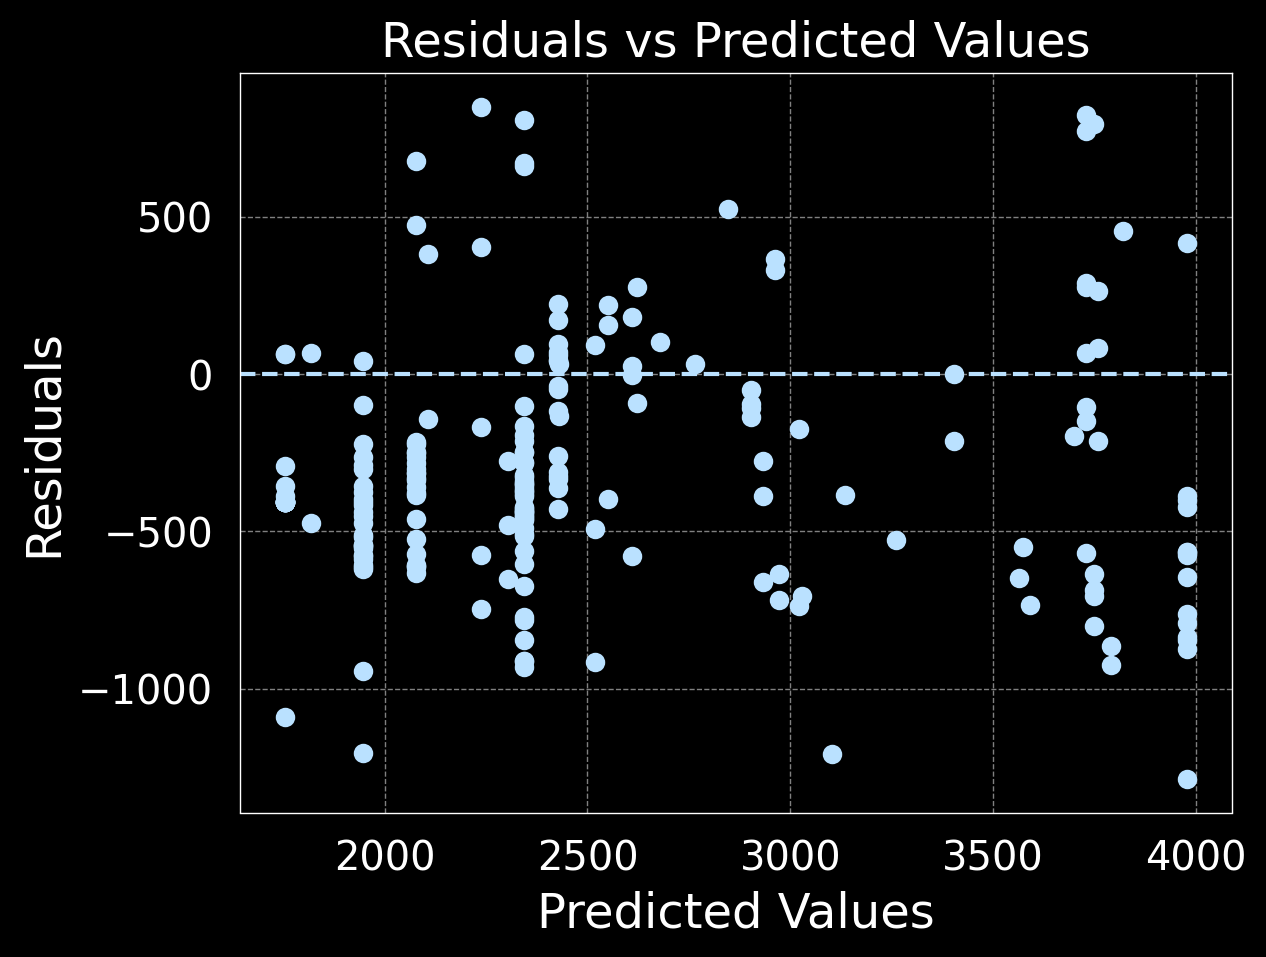

In [33]:
residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.show();